In [1]:
import pandas as pd
from dataset_nuc import NucleiSegmentationDataset
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from model_nuc import HalfDualDecUNetPlusPlus
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import albumentations as A
import torch
from torch.utils import data
import numpy as np
from PIL import Image
import os
from he_randaugment import randaugment
import torchvision.transforms as transforms
import cv2
import ast

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/abk9550/.local/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def color_image_to_mask(color_image):
    color_to_class_map = {
    (255, 255, 255): 0,    # Background
    (200, 0, 0): 1,        # nuclei_tumor
    (255, 0, 255): 2,      # TILs (lymphocytes and plasma cells)
    (150, 200, 150): 3,    # Other cells (histiocytes, stromal cells, etc.)
    (0, 255, 0): 3,
    (51, 0, 51): 3,
    (0, 128, 128): 3,
    (204, 204, 51): 3,
    (102, 26, 51): 3,
    (51, 51, 51): 3
    }

    color_array = np.array(color_image)
    unique_colors = np.unique(color_array.reshape(-1, color_array.shape[2]), axis=0)

    # Erstelle eine leere Maske für die Klassenzuordnung
    mask = np.zeros((color_array.shape[0], color_array.shape[1]), dtype=np.uint8)

    for color in unique_colors:
        color_tuple = tuple(color)
        
        # Bestimme die Klasse, entweder durch explizite Zuordnung oder Standardklasse 3
        class_value = color_to_class_map.get(color_tuple, 3)
        
        is_color = np.all(color_array == color_tuple, axis=-1)
        
        if np.any(is_color):  # Nur wenn die Farbe im Bild vorkommt
            mask[is_color] = class_value
    return mask

Processing ROIs:   0%|                                    | 0/4 [00:00<?, ?it/s]

../dataset/nuclei/training_set_metastatic_roi_014.png


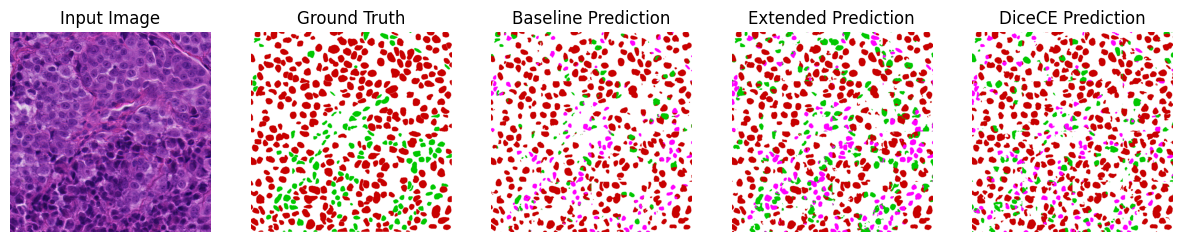

Processing ROIs:  25%|███████                     | 1/4 [00:02<00:07,  2.47s/it]

../dataset/nuclei/training_set_primary_roi_026.png


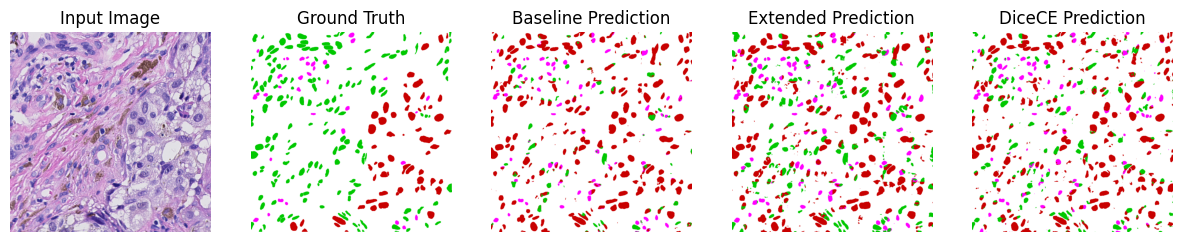

Processing ROIs:  50%|██████████████              | 2/4 [00:04<00:05,  2.50s/it]

../dataset/nuclei/training_set_primary_roi_020.png


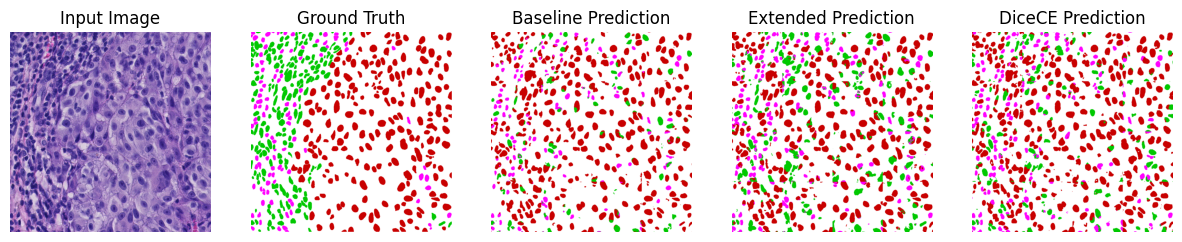

Processing ROIs:  75%|█████████████████████       | 3/4 [00:07<00:02,  2.51s/it]

../dataset/nuclei/training_set_metastatic_roi_081.png


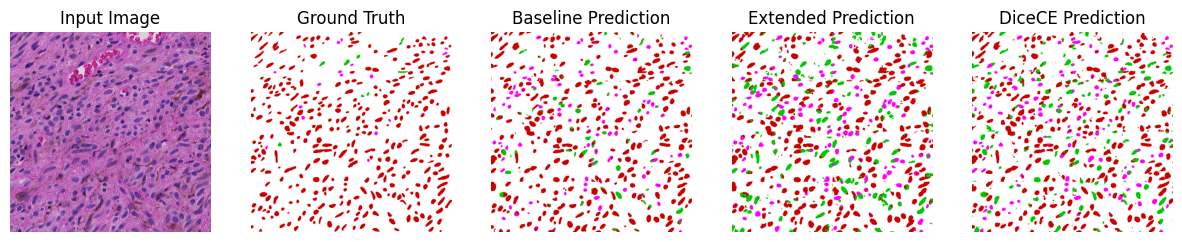

Processing ROIs: 100%|████████████████████████████| 4/4 [00:09<00:00,  2.48s/it]


In [30]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
num_classes = 4
patch_size = 256
class_colors = [
    (255, 255, 255),  # Background
    (200, 0, 0),      # nuclei_tumor
    (255, 0, 255),    # nuclei_lymphocyte
    (0, 200, 0)       # Other cells
]

# Preprocessing functions
def preprocess_baseline(image_path):
    """Preprocess image for the Baseline model."""
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    image = torch.from_numpy(image.copy()) / 255.0  # Scale to [0, 1]
    image = image.permute(2, 0, 1).unsqueeze(0).cuda()  # Rearrange to [1, C, H, W]
    return image

def preprocess_extended_dice(image_path):
    """Preprocess image for Extended Input and Dice models."""
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    normalize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    rgb_image = normalize(image).unsqueeze(0).cuda()  # Add batch dimension
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = torch.tensor(gray_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda() / 255.0
    image = torch.cat((rgb_image, gray_image), dim=1)  # Combine RGB + Grayscale
    return image

num_classes = 4



def apply_color_mapping(mask):
    """Map class values in the mask to RGB colors."""
    
    class_colors = [
    (255, 255, 255),  # Background
    (200, 0, 0),      # nuclei_tumor
    (255, 0, 255),    # nuclei_lymphocyte
    (0, 200, 0)   # Other cells
    ]
    mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for k, color in enumerate(class_colors):
        mask_rgb[mask == k] = color
    return mask_rgb

def process_patches(model, image, patch_size, num_classes):
    """Perform patch-wise inference on the image."""
    _, _, h, w = image.shape
    full_pred = np.zeros((h, w, num_classes), dtype=np.float32)

    # Loop through the image in patches
    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            patch = image[:, :, y:y + patch_size, x:x + patch_size]

            # Pad patch if it exceeds boundaries
            pad_h = patch_size - patch.shape[2] if patch.shape[2] < patch_size else 0
            pad_w = patch_size - patch.shape[3] if patch.shape[3] < patch_size else 0
            if pad_h > 0 or pad_w > 0:
                patch = nn.functional.pad(patch, (0, pad_w, 0, pad_h), mode='constant', value=0)

            with torch.no_grad():
                output = model(patch)
            pred_patch = output.squeeze(0).cpu().numpy()  # Shape: (num_classes, H, W)

            # Transpose pred_patch to (H, W, num_classes)
            pred_patch = np.transpose(pred_patch, (1, 2, 0))

            # Add prediction to full image
            full_pred[y:y + patch_size, x:x + patch_size, :] += pred_patch[:patch.shape[2], :patch.shape[3], :]

    # Convert logits to class predictions
    full_pred = np.argmax(full_pred, axis=-1)
    return full_pred

def visualize_predictions(models, rois, base_path, g_path):
    """Visualize predictions from multiple models."""
    
    for roi in tqdm(rois, desc="Processing ROIs"):
        image_path = os.path.join(base_path, roi + ".tif")
        ground_truth_path = os.path.join(str(g_path), str(roi) + ".png")
        print(ground_truth_path)


        # Process predictions for each model
        predictions = {}
        for model_name, model in models.items():
            if model_name == "Baseline":
                image = preprocess_baseline(image_path)
            else:
                image = preprocess_extended_dice(image_path)

            predictions[model_name] = process_patches(model, image, patch_size, num_classes)

        # Map masks to RGB for visualization
        ground_truth = Image.open(ground_truth_path).convert('RGB')  # Load as RGB
        ground_truth = color_image_to_mask(ground_truth)  # Convert to class mask
        ground_truth_rgb = apply_color_mapping(ground_truth)
        pred_rgb = {k: apply_color_mapping(v) for k, v in predictions.items()}

        # Plot input image, ground truth, and predictions
        input_image = np.array(Image.open(image_path))  # Reload for display
        fig, axes = plt.subplots(1, len(models) + 2, figsize=(15, 5))
        axes[0].imshow(input_image)
        axes[0].set_title("Input Image")
        axes[0].axis("off")

        axes[1].imshow(ground_truth_rgb)
        axes[1].set_title("Ground Truth")
        axes[1].axis("off")

        for idx, (model_name, pred) in enumerate(pred_rgb.items(), start=2):
            axes[idx].imshow(pred)
            axes[idx].set_title(f"{model_name} Prediction")
            axes[idx].axis("off")

        plt.show()

# Load models
models = {
    "Baseline": nn.Sequential(HalfDualDecUNetPlusPlus(in_channel=3), nn.Sigmoid()).cuda(),
    "Extended": nn.Sequential(HalfDualDecUNetPlusPlus(in_channel=4), nn.Sigmoid()).cuda(),
    "DiceCE": nn.Sequential(HalfDualDecUNetPlusPlus(in_channel=4), nn.Sigmoid()).cuda(),

}

# Load weights for each model
models["Baseline"][0].load_state_dict(torch.load(r"logs/M_Baseline/best_f1.pt"))
models["DiceCE"][0].load_state_dict(torch.load(r"logs/M_DiceCE/best_f1.pt"))
models["Extended"][0].load_state_dict(torch.load(r"logs/M_Extend/best_f1.pt"))

# ROIs and paths
rois = [
    "training_set_metastatic_roi_014",
    "training_set_primary_roi_026",
    "training_set_primary_roi_020",
    "training_set_metastatic_roi_081"
]
base_path = r"../dataset/01_training_dataset_tif_ROIs"
ground_truth_path = r"../dataset/nuclei"

# Visualize predictions
visualize_predictions(models, rois, base_path, ground_truth_path)


In [24]:
# Define the paths and ROIs
rois = [
    "training_set_metastatic_roi_014",
    "training_set_primary_roi_026",
    "training_set_primary_roi_020",
    "training_set_metastatic_roi_081"
]

base_path = r"../dataset/01_training_dataset_tif_ROIs"
ground_truth_path = r"../dataset/nuclei"



# Loop through ROIs and preprocess images
for roi in rois:
    image_path = os.path.join(base_path, roi + ".tif")  # Adjust extension if needed
    ground_truth_path = os.path.join(ground_truth_path, roi + ".png")  # Adjust naming if needed
    
    # Preprocess for each model
    print(f"Processing ROI: {roi}")
    baseline_image = preprocess_baseline(image_path)
    extended_dice_image = preprocess_extended_dice(image_path)

Processing ROI: training_set_metastatic_roi_014
Processing ROI: training_set_primary_roi_026
Processing ROI: training_set_primary_roi_020
Processing ROI: training_set_metastatic_roi_081
